# Exporting images out of DEA

###Background:

Data in the DataCube is represented as XArray Dataset objects. Xarray follows a data model for representing data which is very similar to the one defined in the NetCDF4 file format. NetCDF4 is a file format designed to store scientific numerical data. Multidimensional arrays can be naturally stored in this format together with dimensions information as well as metadata.

### import modules and scripts

In [3]:
%matplotlib inline

from datacube import Datacube
import xarray as xr

dc = Datacube(app='Sentinel2')

### Saving data as NetCDF4

In [4]:
import datacube, xarray
from datacube.drivers.netcdf import write_dataset_to_netcdf

-34.928889, 138.601111
query = {
        'lat': (-34.90, -34.96),
        'lon': (138.57, 138.63),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'measurements': ["nbar_red","nbar_green","nbar_blue"],
        'time': ('2019-01-01', '2019-03-01')
        }

adelaide = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)


write_dataset_to_netcdf(adelaide, 'adelaide2019.nc')

### Reading the images back

Using `XArray` functionality, NetCDF files can be read into `Dataset` objects. These objects can be used as if they where DEA objects using DEA functionality to plot, merge or compare with other objects.

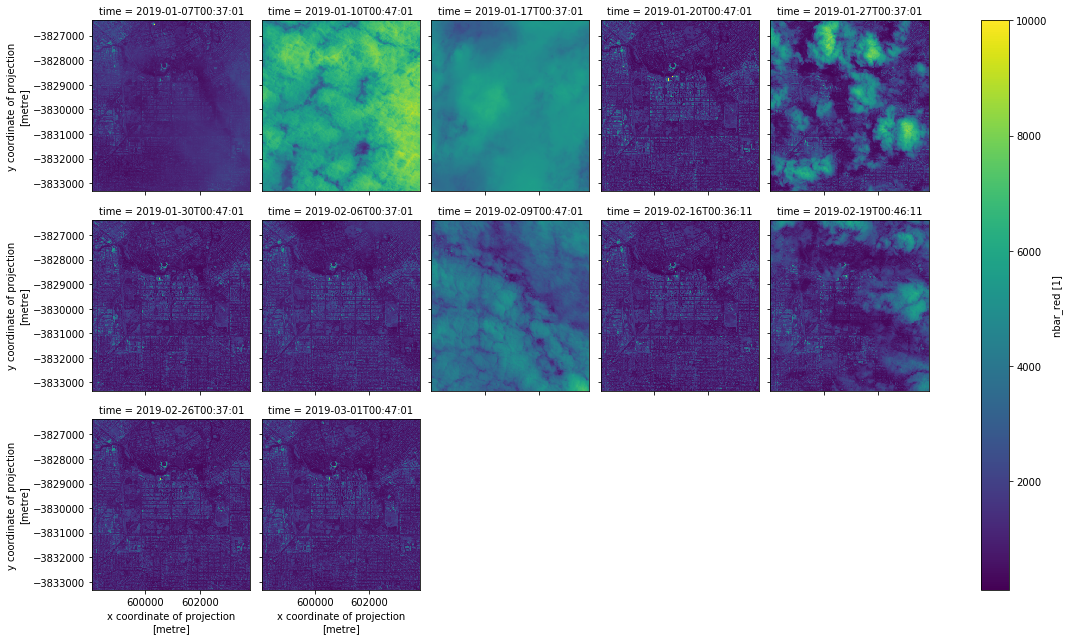

In [5]:
ds = xr.open_dataset('adelaide2019.nc')

ds.nbar_red.plot(col='time', col_wrap=5)

### Real Colour RGBs:

From the images above, can you detect a one with no clouds and plot a real colour RGB image of Adelaide? _Hint_: Substitute the `?` symbols with the right values.

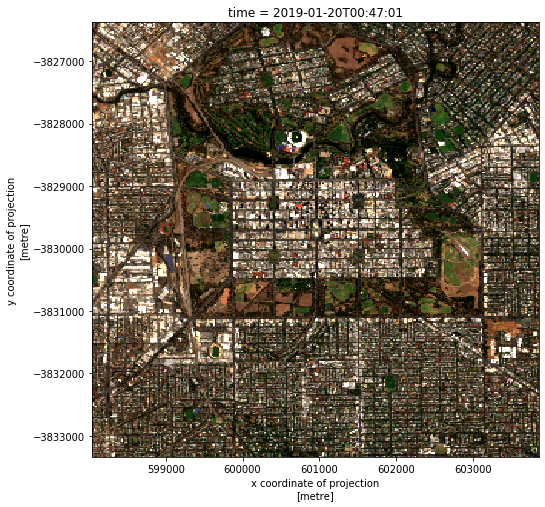

In [8]:
ds[['nbar_red', 'nbar_green', 'nbar_blue']].isel(time=3).to_array().plot.imshow(robust=True, figsize=(8,8))

### DEA requests with vector data

Sometimes, our area of interest is defined in external files containing a polygon or other forms of vector data. These files can be used directly into DEA query objects to select the data of interest. For example, the following file, stored locally, contains a shapefile defining an area of interest.

In [9]:
poly_path = 'data/reeves_lake_for_demo.shp'

### Plotting polygon data

`Geopandas` is a Python library for working with geospatial data. It can read a large number of formats and offers convenient functionality to analyse and represent geospatial data.

<Figure size 432x288 with 0 Axes>

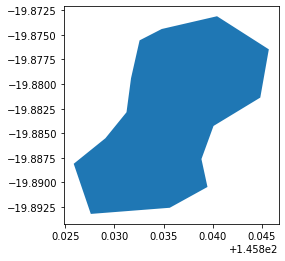

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

Using the `open_polygon_from_shapefile` function from the DEA toolbox, we can extract the geometry information and pass it directly into the DEA query instead of specifying `lat` and `lon` values.

In [11]:
import sys
sys.path.append('./Scripts')
import DEADataHandling
import DEAPlotting

GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(poly_path)

query = {
    'time': ('2016-05-01', '2016-05-30'), 
    'geopolygon': GEOM,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10)
}

Load cloud free Sentinel data for all sensors (S2A, S2B) for the above query. Setting 
`satellite_metadata=True` will return the data with a variable that gives the abbreviation
of the satellite that made the observation. Masked_prop allows removing timesteps with missing data greater than masked proportion, useful when animating/communicating results.

In [12]:
s2 = DEADataHandling.load_clearsentinel2(dc=dc, query=query, sensors=['s2a', 's2b'],
                                         bands_of_interest=['fmask','nbart_green','nbart_nir_1','nbart_swir_2'], 
                                         masked_prop=0, satellite_metadata=True)

Loading s2a pixel quality
    Loading 3 filtered s2a timesteps
Loading s2b pixel quality
    Skipping s2b; no valid data for query
Combining and sorting s2a data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### Print and plot sample of resulting data (false color) 

<Figure size 432x288 with 0 Axes>

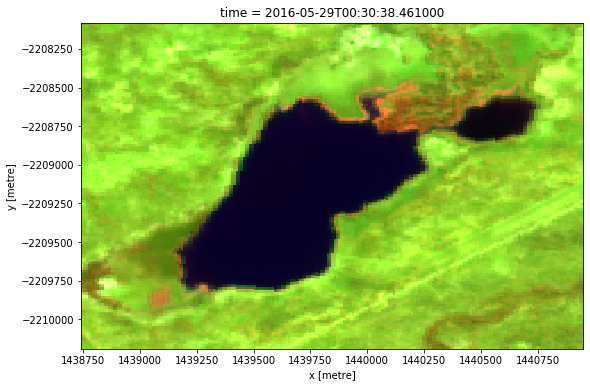

In [13]:
# Plot sample of resulting data for an index (timestep) of your choice
plt.clf()
DEAPlotting.rgb(s2, bands=['nbart_nir_1', 'nbart_swir_2', 'nbart_green'], index=2)

### Exporting data in GeoTIFF format

Although NetCDF is a convenient format to represent and organise geospatial data it is not always the most compatible format to use with GIS systems and share data with other users. GeoTIFF is probably the most well-known format for geospatial data and constitutes the de-facto standard in the geospatial community. DEA data can also be exported in this format making use of a library called `rasterio` which is a Python wrapper of GDAL. For the purposes of this tutorial we are going to make use of a function called `dataset_to_geotiff` with makes use of `rasterio` to save `XArray` data into GeoTiffs.

Before demonstrating how to save an image as a GeoTiff, let's clean the previous object to remove unwanted variables using `drop` and convert data into float32 type to save some space:

In [14]:
import numpy as np

s2 = s2.drop('fmask')
s2 = s2.drop('data_perc')
s2 = s2.drop('satellite')

s2['nbart_green'] = s2.nbart_green.astype(np.float32)
s2['nbart_nir_1'] = s2.nbart_nir_1.astype(np.float32)
s2['nbart_swir_2'] = s2.nbart_swir_2.astype(np.float32)


s2

<xarray.Dataset>
Dimensions:       (time: 3, x: 221, y: 211)
Coordinates:
  * time          (time) datetime64[ns] 2016-05-09T00:30:38.460000 ... 2016-05-29T00:30:38.461000
  * y             (y) float64 -2.208e+06 -2.208e+06 ... -2.21e+06 -2.21e+06
  * x             (x) float64 1.439e+06 1.439e+06 ... 1.441e+06 1.441e+06
Data variables:
    nbart_green   (time, y, x) float32 nan nan nan nan ... 810.0 878.0 740.0
    nbart_nir_1   (time, y, x) float32 nan nan nan nan ... 2468.0 2481.0 2248.0
    nbart_swir_2  (time, y, x) float32 nan nan nan nan ... 3179.0 3179.0 3047.0
Attributes:
    crs:      EPSG:3577

Now we save the object calling the `dataset_to_geotiff` function

In [15]:
import GeoTiffExport

GeoTiffExport.dataset_to_geotiff('reeves_lake.tiff', s2.isel(time=2))

### GDAL on the command line

GDAL commands such as `gdal_translate` or `gdalinfo` can be called within jupyter notebooks using the `!` symbol to call the shell:

In [16]:
!gdalinfo -mm reeves_lake.tiff

Driver: GTiff/GeoTIFF
Files: reeves_lake.tiff
Size is 221, 211
Coordinate System is:
PROJCS["GDA94 / Australian Albers",
    GEOGCS["GDA94",
        DATUM["Geocentric_Datum_of_Australia_1994",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6283"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4283"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["standard_parallel_1",-18],
    PARAMETER["standard_parallel_2",-36],
    PARAMETER["latitude_of_center",0],
    PARAMETER["longitude_of_center",132],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","3577"]]
Origin = (1438740.000000000000000

### Loading GeoTiffs

Geotiff files can be read into numpy arrays using `rasterio`. The geospatial information such as coordinates and projection is lost but can be recovered and potentially written into a new `XArray` object, but we leave this as an exercise.

In [17]:
import rasterio

with rasterio.open('reeves_lake.tiff', 'r') as ds:
    print(ds.read().shape)

(3, 211, 221)


### Exercise:

`rasterio` reads a GeoTiff and returns a numpy array which contains the bands in the first dimension. If we want to plot this image using matplotlib, there are some transformations that we need to apply to this array:

1. The dimension containing the bands should come last: _Hint_: Look into numpy `swapaxes` doc.
2. Some reflectance values in the image are quite high, you'll need clip values in the range [0-2000]: Look into numpy `clip` doc.
3. Matplotlib `imshow` can only plot float RGB images of type if they are in the range [0-1] so you'll need to normalise the data.

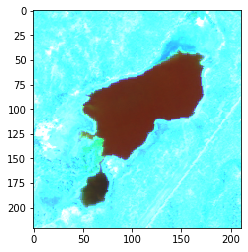

In [18]:
with rasterio.open("reeves_lake.tiff", 'r') as ds:
    ### Your code goes here

### Exporting images for non-scientific purposes

Sometime, we might want to export the images that we want to generate in DEA in a simple format for media publications or other non-scientific purposes. PNG and JPEG are popular image formats to share our satellite results and Python offers a many ways to work with these formats. For this tutorial we are going to use `imageio` which is a very simple library for working with image files.

Let's request some data for Darwin:

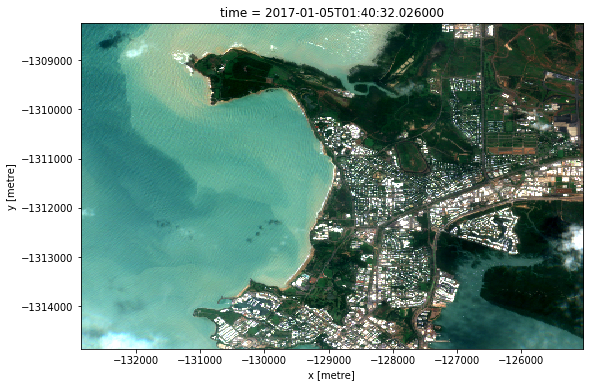

In [19]:
query = {
        'lat': (-12.40, -12.46),
        'lon': (130.80, 130.87),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'measurements': ["nbar_red","nbar_green","nbar_blue"],
        'time': ('2017-01-01', '2017-02-01')
        }

darwin = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

DEAPlotting.rgb(darwin, bands=['nbar_red', 'nbar_green', 'nbar_blue'], index=0)

### Exercise:

We are going to use `imageio` to save the previous image into a PNG image. To create this image we need to pass a valid numpy array to `imagio` so you'll need to follow a few steps to go from the DEA `Dataset` into this numpy array: 

1. Select the first temporal index from the Dataset object
2. Create a 3-d numpy array using the red, green and blue bands: _Hint_: Look into numpy `dstack` doc.
3. Some reflectance values in the image are quite high, you'll need clip values in the range [0-3500]: Look into numpy `clip` doc.
3. `imageio` uses RGB images encoded as `uint8` type with values ranging [0-255]. 
    * Normalise the array data into [0-255]
    * Convert the array to `uint8` datatype: _Hint_: Remember `.astype()`?

In [20]:
import imageio

### Your code goes here

#imageio.imwrite("darwin.png",#3D array)